# Autocorrelation-based boundary detection

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from libpysal.graph import Graph
from esda import Moran_Local, Geary_Local
from sklearn.decomposition import PCA

Load all buildings represented as points.

In [2]:
complete = gpd.read_parquet("/data/uscuni-boundaries/classification/v202511/").reset_index(drop=True)

In [30]:
complete

,geometry,level_7_label,area,level_3
0,POINT (4292815.658 3392096.245),36,124.350225,4
1,POINT (4292819.583 3392091.712),36,1.402272,4
2,POINT (4292810.814 3392094.661),36,14.988636,4
3,POINT (4292809.522 3392043.982),36,23.192214,4
4,POINT (4294130.039 3392097.282),57,65.245111,5
...,...,...,...,...
159599314,POINT (4128415.517 2896813.41),26,55.429514,3
159599315,POINT (4128415.095 2896819.459),26,59.189652,3
159599316,POINT (4128396.856 2896812.442),26,34.162277,3
159599317,POINT (4128396.626 2896802.56),26,16.241510,3


Map ids to level 3.

In [4]:
final_clusters = pd.read_parquet(
    "/data/uscuni-ulce/processed_data/clusters/cluster_mapping_v10.pq"
)
complete["level_3"] = complete.level_7_label.map(final_clusters[3])

Make a grid

In [5]:
grid_size = 50_000

In [6]:
bds = complete.total_bounds
bds

array([1548185.539145  ,  942249.56623092, 5378847.07173358,
       3799811.41843362])

In [7]:
x = np.arange(bds[0], bds[2], grid_size)
y = np.arange(bds[1], bds[3], grid_size)

In [8]:
xs, ys = np.meshgrid(x, y)

In [9]:
grid = gpd.GeoSeries.from_xy(x=xs.flatten(), y=ys.flatten(), crs=complete.crs).buffer(
    grid_size / 2, cap_style="square"
)

Join grid label to points

In [10]:
grid = grid.to_frame("geometry")
joined = complete.sjoin(grid, predicate="within")

Group by grid label and get counts by class.

In [12]:
counts = joined.groupby("index_right").level_3.value_counts().unstack().fillna(0)
counts = counts.div(counts.sum(axis=1), axis=0)
counts

level_3,1,2,3,4,5,6,7,8
index_right,,,,,,,,
5,0.094316,0.042292,0.033973,0.098306,0.128195,0.270845,0.066629,0.265443
7,0.422699,0.000000,0.040491,0.019018,0.058282,0.087117,0.047853,0.324540
8,0.073837,0.009737,0.239632,0.226650,0.179679,0.033718,0.067616,0.169131
9,0.700855,0.123077,0.000000,0.001709,0.000000,0.000000,0.013675,0.160684
80,0.162452,0.035518,0.010065,0.108385,0.167776,0.068125,0.124272,0.323407
...,...,...,...,...,...,...,...,...
4460,0.000000,0.000000,0.007194,0.410072,0.582734,0.000000,0.000000,0.000000
4461,0.002127,0.000000,0.057781,0.385502,0.331266,0.000000,0.223325,0.000000
4462,0.002161,0.000000,0.246345,0.426084,0.296937,0.000000,0.027075,0.001398


Join

In [13]:
grid_data = pd.concat([grid, counts], axis=1)

Drop cells outside of the area

In [14]:
grid_data = grid_data.dropna().reset_index()

Build contiguity graph and use it ot compute Local Moran's I. 

In [15]:
contig = Graph.build_contiguity(grid_data, rook=False).transform('r')

lisa = Moran_Local(grid_data[3].fillna(0), contig)

/home/martin/dev/boundaries_of_change/.pixi/envs/default/lib/python3.12/site-packages/esda/moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


Get bounddaries for each cluster type and each p value

In [16]:
boundaries = []
for i in range(1, 9):
    for p in [0.1, 0.05, 0.01]:
        lisa = Moran_Local(grid_data[i].fillna(0), contig)
        lisa_graph = Graph.build_block_contiguity(lisa.get_cluster_labels() == "High-High")
        inter = contig.difference(lisa_graph)
        boundaries.append(inter)

        lisa_graph = Graph.build_block_contiguity(lisa.get_cluster_labels() == "Low-Low")
        inter = contig.difference(lisa_graph)
        boundaries.append(inter)

/home/martin/dev/boundaries_of_change/.pixi/envs/default/lib/python3.12/site-packages/esda/moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/home/martin/dev/boundaries_of_change/.pixi/envs/default/lib/python3.12/site-packages/esda/moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/home/martin/dev/boundaries_of_change/.pixi/envs/default/lib/python3.12/site-packages/esda/moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/home/martin/dev/boundaries_of_change/.pixi/envs/default/lib/python3.12/site-packages/esda/moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/home/martin/dev/boundaries_of_change/.pixi/envs/default/lib/python3.12/site-packages/esda/moran.py:1350: RuntimeWarning: invalid value encountered in d

Plot the boundaries

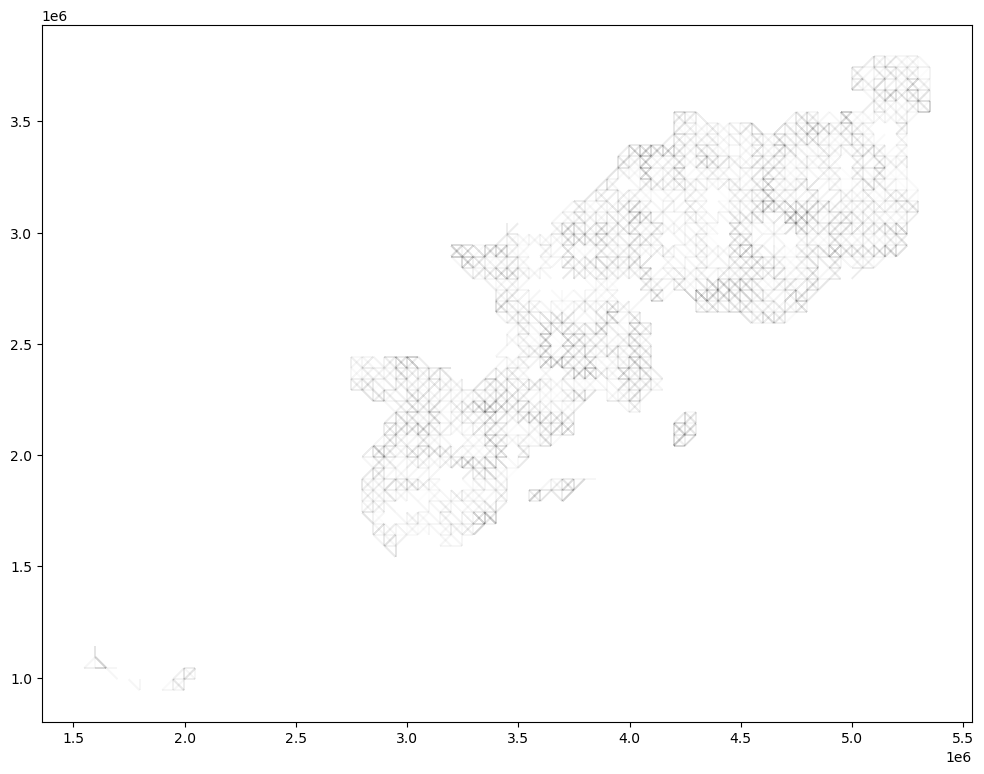

In [19]:
f, ax = plt.subplots(figsize=(12, 12))

for bound in boundaries:
    bound.plot(grid_data, ax=ax, nodes=False, edge_kws=dict(alpha=.01))
ax.set_aspect('equal')

Using PCA

In [20]:
pca = PCA(3).fit(grid_data.iloc[:, 2:].values)

Check variance ration

In [21]:
pca.explained_variance_ratio_

array([0.44624297, 0.24247289, 0.17279047])

Get PCAs

In [22]:
comps = pca.transform(grid_data.iloc[:, 2:].values)

Get LISA of PCA of proportions

In [28]:
lisa_comp = Moran_Local(comps[:, 2], contig)

/home/martin/dev/boundaries_of_change/.pixi/envs/default/lib/python3.12/site-packages/esda/moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


<Axes: >

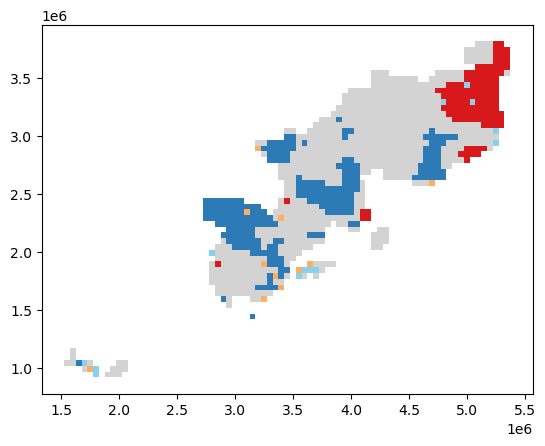

In [29]:
lisa_comp.plot(grid_data)